In [1]:
import jax
import jax.numpy as np
from jax import random, grad, vmap, jit, hessian
from jax.experimental import optimizers
from jax.experimental.ode import odeint
from jax.nn import relu
from jax.config import config
from jax import lax
from jax.flatten_util import ravel_pytree


import itertools
from functools import partial
from torch.utils import data
from tqdm import trange, tqdm
import matplotlib.pyplot as plt

from scipy.interpolate import griddata
%matplotlib inline

/scratch/sifanw/anaconda3/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


# Architectures

In [2]:
# Define the neural net
def MLP(layers, activation=relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = np.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply

# Define the neural net
def modified_MLP(layers, activation=relu):
  def xavier_init(key, d_in, d_out):
      glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
      W = glorot_stddev * random.normal(key, (d_in, d_out))
      b = np.zeros(d_out)
      return W, b

  def init(rng_key):
      U1, b1 =  xavier_init(random.PRNGKey(12345), layers[0], layers[1])
      U2, b2 =  xavier_init(random.PRNGKey(54321), layers[0], layers[1])
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          W, b = xavier_init(k1, d_in, d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return (params, U1, b1, U2, b2) 

  def apply(params, inputs):
      params, U1, b1, U2, b2 = params
      U = activation(np.dot(inputs, U1) + b1)
      V = activation(np.dot(inputs, U2) + b2)
      for W, b in params[:-1]:
          outputs = activation(np.dot(inputs, W))
          inputs = np.multiply(outputs, U) + np.multiply(1 - outputs, V) 
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply

# Data Sampler

In [3]:
class DataGenerator(data.Dataset):
    def __init__(self, u, y, s, 
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u
        self.y = y
        self.s = s
        
        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        s = self.s[idx,:]
        y = self.y[idx,:]
        u = self.u[idx,:]
        # Construct batch
        inputs = (u, y)
        outputs = s
        return inputs, outputs

# Physics-informed DeepONet

In [4]:
# Define the model
class PI_DeepONet:
    def __init__(self, branch_layers, trunk_layers, D, k):    
        
        self.D = D
        self.k = k
        
        # Network initialization and evaluation functions
        self.branch_init, self.branch_apply = modified_MLP(branch_layers, activation=np.tanh)
        self.trunk_init, self.trunk_apply = modified_MLP(trunk_layers, activation=np.tanh)

        # Initialization
        branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
        trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
        params = (branch_params, trunk_params)

        # Use optimizers to set optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=5000, decay_rate=0.9)
        self.opt_init, self.opt_update, self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params)
        _, self.unravel = ravel_pytree(params)

        self.itercount = itertools.count()
        
        # Logger
        self.loss_log = []
        self.loss_ics_log = []
        self.loss_bcs_log = []
        self.loss_res_log = []

    # Define the opeartor net
    def operator_net(self, params, u, x, t):
        y = np.stack([x,t])

        branch_params, trunk_params = params
        B = self.branch_apply(branch_params, u)
        T = self.trunk_apply(trunk_params, y)
        outputs = np.sum(B * T)
        return   outputs
    
    # Define the residual net
    def residual_net(self, params, u, x, t):
        s = self.operator_net(params, u, x, t)
        s_t = grad(self.operator_net, argnums=3)(params, u, x, t)
        s_x = grad(self.operator_net, argnums=2)(params, u, x, t)
        s_xx= grad(grad(self.operator_net, argnums=2), argnums=2)(params, u, x, t)

        res = s_t - self.D * s_xx - self.k * s**2 
        return res
    
    
    @partial(jit, static_argnums=(0,))
    def loss_ics(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])
        # Compute loss
        loss = np.mean((outputs.flatten() - s_pred)**2)
        return loss

    @partial(jit, static_argnums=(0,))
    def loss_bcs(self, params, batch):
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])
        # Compute loss
        loss = np.mean((outputs.flatten() - s_pred)**2)
        return loss

    @partial(jit, static_argnums=(0,))
    def loss_res(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        pred = vmap(self.residual_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])
        # Compute loss
        loss = np.mean((outputs.flatten() - pred)**2)
        return loss   

    @partial(jit, static_argnums=(0,))
    def loss(self, params, ics_batch, bcs_batch, res_batch):
        loss_ics = self.loss_ics(params, ics_batch)
        loss_bcs = self.loss_bcs(params, bcs_batch)
        loss_res = self.loss_res(params, res_batch)
        loss = loss_ics + loss_bcs +  loss_res
        return loss 

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, ics_batch, bcs_batch, res_batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, ics_batch, bcs_batch, res_batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, ics_dataset, bcs_dataset, res_dataset, nIter = 10000):
        ics_data = iter(ics_dataset)
        bcs_data = iter(bcs_dataset)
        res_data = iter(res_dataset)

        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            ics_batch= next(ics_data)
            bcs_batch= next(bcs_data)
            res_batch = next(res_data)

            self.opt_state = self.step(next(self.itercount), self.opt_state, ics_batch, bcs_batch, res_batch)
            
            if it % 1000 == 0:
                params = self.get_params(self.opt_state)
                
                loss_value = self.loss(params, ics_batch, bcs_batch, res_batch)
                loss_ics_value = self.loss_ics(params, ics_batch)
                loss_bcs_value = self.loss_bcs(params, bcs_batch)
                loss_res_value = self.loss_res(params, res_batch)

                self.loss_log.append(loss_value)
                self.loss_ics_log.append(loss_ics_value)
                self.loss_bcs_log.append(loss_bcs_value)
                self.loss_res_log.append(loss_res_value)

                pbar.set_postfix({'Loss': loss_value, 
                                  'loss_ics' : loss_ics_value, 
                                  'loss_bcs' : loss_bcs_value, 
                                  'loss_res': loss_res_value})
           
    # Evaluates predictions at test points  
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1])
        return s_pred

    @partial(jit, static_argnums=(0,))
    def predict_res(self, params, U_star, Y_star):
        r_pred = vmap(self.residual_net, (None, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1])
        return r_pred

In [5]:
# Use double precision to generate data (due to GP sampling)
def RBF(x1, x2, params):
    output_scale, lengthscales = params
    diffs = np.expand_dims(x1 / lengthscales, 1) - \
            np.expand_dims(x2 / lengthscales, 0)
    r2 = np.sum(diffs**2, axis=2)
    return output_scale * np.exp(-0.5 * r2)

def solve_ADR(key, T, Nx, Nt,  P, length_scale):
    """Solve 1D
    u_t = (k(x) u_x)_x - v(x) u_x + g(u) + f(x)
    with zero initial and boundary conditions.
    """
    xmin, xmax = 0, 1
    tmin, tmax = 0, T
    k = lambda x: 0.001*np.ones_like(x)
    v = lambda x: np.zeros_like(x)
    g = lambda u: 0.001*u ** 2
    dg = lambda u: 0.002 * u
    f_fn = lambda x: np.zeros_like(x)
    # u0 = lambda x: np.zeros_like(x)
    # Nx = 100
    # Nt = 100

    # Generate a GP sample
    N = 512
    gp_params = (10.0, length_scale)
    jitter = 1e-10
    X = np.linspace(xmin, xmax, N)[:,None]
    K = RBF(X, X, gp_params)
    L = np.linalg.cholesky(K + jitter*np.eye(N))
    gp_sample = np.dot(L, random.normal(key, (N,)))
    # Create a callable interpolation function  
    u0 = lambda x: np.interp(x, X.flatten(), gp_sample) * x * (1 - x)

    # Create grid
    x = np.linspace(xmin, xmax, Nx)
    t = np.linspace(tmin, tmax, Nt)
    h = x[1] - x[0]
    dt = t[1] - t[0]
    h2 = h ** 2

    # Compute coefficients and forcing
    k = k(x)
    v = v(x)
    f = f_fn(x)

    # Compute finite difference operators
    D1 = np.eye(Nx, k=1) - np.eye(Nx, k=-1)
    D2 = -2 * np.eye(Nx) + np.eye(Nx, k=-1) + np.eye(Nx, k=1)
    D3 = np.eye(Nx - 2)
    M = -np.diag(D1 @ k) @ D1 - 4 * np.diag(k) @ D2
    m_bond = 8 * h2 / dt * D3 + M[1:-1, 1:-1]
    v_bond = 2 * h * np.diag(v[1:-1]) @ D1[1:-1, 1:-1] + 2 * h * np.diag(
        v[2:] - v[: Nx - 2]
    )
    mv_bond = m_bond + v_bond
    c = 8 * h2 / dt * D3 - M[1:-1, 1:-1] - v_bond

    # Initialize solution and apply initial condition
    u = np.zeros((Nx, Nt))

    u = u.at[:,0].set(u0(x))
    
    # Time-stepping update
    def body_fn(i, u):
        gi = g(u[1:-1, i])
        dgi = dg(u[1:-1, i])
        h2dgi = np.diag(4 * h2 * dgi)
        A = mv_bond - h2dgi
        b1 = 8 * h2 * (0.5 * f[1:-1] + 0.5 * f[1:-1] + gi)
        b2 = (c - h2dgi) @ u[1:-1, i].T
        u = u.at[1:-1, i + 1].set(np.linalg.solve(A, b1 + b2))
        return u
    # Run loop
    UU = lax.fori_loop(0, Nt-1, body_fn, u)

    # Input sensor locations and measurements
    # xx = np.linspace(xmin, xmax, m)
    u = f_fn(x)
    # Output sensor locations and measurements
    key = random.PRNGKey(100)
    idx = random.randint(key, (P,2), 0, max(Nx,Nt))
    y = np.concatenate([x[idx[:,0]][:,None], t[idx[:,1]][:,None]], axis = 1)
    s = UU[idx[:,0], idx[:,1]]
    # x, t: sampled points on grid
    return (x, t, UU), (u0(x), y, s)

def generate_one_training_data(key, P, Q):
    (x, t, UU), (u, y, s) = solve_ADR(key, dT, Nx , Nt, P, length_scale)

    subkeys = random.split(key, 3)

    u_ic_train = np.tile(u, (P,1))

    x_ic = np.linspace(0, 1, P)[:, None]
    t_ic = np.zeros((P, 1))
    y_ic_train = np.hstack([x_ic, t_ic])

    s_ic_train = u.flatten()

    u_bc_train = np.tile(u, (P,1))

    x_bc1 = np.zeros((P // 2, 1))
    x_bc2 = np.ones((P // 2, 1))
    x_bcs = np.vstack((x_bc1, x_bc2))
    t_bcs = random.uniform(key = subkeys[0], shape = (P, 1), minval=0.0, maxval=dT)

    y_bc_train = np.hstack([x_bcs, t_bcs])
    s_bc_train = np.zeros((P,1))

    u_r_train = np.tile(u, (Q,1))
    x_r = random.uniform(key = subkeys[1], shape = (Q, 1), minval=0.0, maxval=1.0)
    t_r = random.uniform(key = subkeys[2], shape = (Q, 1), minval=0.0, maxval=dT)
    y_r_train = np.hstack([x_r, t_r])
    s_r_train = np.zeros((Q, 1))

    return u_ic_train, y_ic_train, s_ic_train, u_bc_train, y_bc_train, s_bc_train, u_r_train, y_r_train, s_r_train


def generate_one_test_data(key, T, P):
    (x, t, UU), (u, y, s) = solve_ADR(key, T, Nx , Nt, P, length_scale)

    XX, TT = np.meshgrid(x, t)

    u_test = np.tile(u, (P**2,1))
    y_test = np.hstack([XX.flatten()[:,None], TT.flatten()[:,None]])
    s_test = UU.flatten()

    return u_test, y_test, s_test


def generate_training_data(key, N, P, Q):
    config.update("jax_enable_x64", True)
    keys = random.split(key, N)
    u_ic_train, y_ic_train, s_ic_train, u_bc_train, y_bc_train, s_bc_train, u_r_train, y_r_train, s_r_train = vmap(generate_one_training_data, (0, None, None))(keys, P, Q)

    u_ic_train = np.float32(u_ic_train.reshape(N * P,-1))
    y_ic_train = np.float32(y_ic_train.reshape(N * P,-1))
    s_ic_train = np.float32(s_ic_train.reshape(N * P,-1))

    u_bc_train = np.float32(u_bc_train.reshape(N * P,-1))
    y_bc_train = np.float32(y_bc_train.reshape(N * P,-1))
    s_bc_train = np.float32(s_bc_train.reshape(N * P,-1))

    u_r_train = np.float32(u_r_train.reshape(N * Q,-1))
    y_r_train = np.float32(y_r_train.reshape(N * Q,-1))
    s_r_train = np.float32(s_r_train.reshape(N * Q,-1))

    config.update("jax_enable_x64", False)
    return u_ic_train, y_ic_train, s_ic_train, u_bc_train, y_bc_train, s_bc_train, u_r_train, y_r_train, s_r_train


def generate_test_data(key, N, T, P):

    config.update("jax_enable_x64", True)
    keys = random.split(key, N)

    u_test, y_test, s_test = vmap(generate_one_test_data, (0, None, None))(keys, T, P)

    u_test = np.float32(u_test.reshape(N * P**2,-1))
    y_test = np.float32(y_test.reshape(N * P**2,-1))
    s_test = np.float32(s_test.reshape(N * P**2,-1))

    config.update("jax_enable_x64", False)
    return u_test, y_test, s_test

In [6]:
key = random.PRNGKey(3)

# GRF
length_scale = 0.2

dT = 1.0

# Resolution of the solution
Nx = 100
Nt = 100

N = 10000
m = Nx
P_train = 100 
Q_train = 100

u_ic_train, y_ic_train, s_ic_train, u_bc_train, y_bc_train, s_bc_train, u_r_train, y_r_train, s_r_train = generate_training_data(key, N, P_train, Q_train)

In [7]:
# Initialize model
branch_layers = [m, 100, 100, 100, 100, 100]
trunk_layers =  [2, 100, 100, 100, 100, 100]
model = PI_DeepONet(branch_layers, trunk_layers, D=0.001, k=0.001)

In [8]:
# Create data set
batch_size = 10000
ics_dataset = DataGenerator(u_ic_train, y_ic_train, s_ic_train, batch_size)
bcs_dataset = DataGenerator(u_bc_train, y_bc_train, s_bc_train, batch_size)
res_dataset = DataGenerator(u_r_train, y_r_train, s_r_train, batch_size)

In [9]:
# # Train
# model.train(ics_dataset, bcs_dataset, res_dataset, nIter=200000)

In [10]:
# Save the trained model and losses
# flat_params, _  = ravel_pytree(model.get_params(model.opt_state))
# np.save('DR_params.npy', flat_params)
# np.save('DR_loss_res.npy', model.loss_res_log)
# np.save('DR_loss_ics.npy', model.loss_ics_log)
# np.save('DR_loss_bcs.npy', model.loss_bcs_log)
# np.save('DR_loss_test.npy', model.s_error_log)

# Restore the trained model
params = model.unravel(np.load('DR_params.npy'))
loss_ics = np.load('DR_loss_ics.npy')
loss_bcs = np.load('DR_loss_bcs.npy')
loss_res = np.load('DR_loss_res.npy')

# Plot

In [11]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='serif')
plt.rcParams.update({
                      "text.usetex": True,
                      "font.family": "serif",
                     'text.latex.preamble': r'\usepackage{amsmath}',
                      'font.size': 20,
                      'lines.linewidth': 3,
                      'axes.labelsize': 20,  # fontsize for x and y labels (was 10)
                      'axes.titlesize': 22,
                      'xtick.labelsize': 20,
                      'ytick.labelsize': 20,
                      'legend.fontsize': 20,
                      'axes.linewidth': 2})

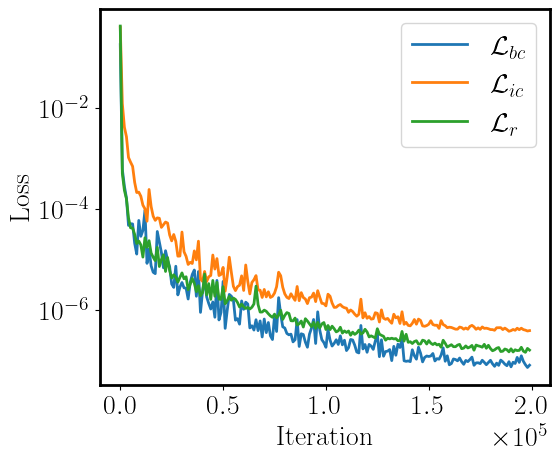

In [12]:
# Losses
fig = plt.figure(figsize = (6,5))

iters = 1000 * np.arange(len(loss_ics))
plt.plot(iters, loss_bcs, lw=2, label='$\mathcal{L}_{bc}$')
plt.plot(iters, loss_ics, lw=2, label='$\mathcal{L}_{ic}$')
plt.plot(iters, loss_res, lw=2, label='$\mathcal{L}_{r}$')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.tight_layout()
plt.show()

In [13]:
key = random.PRNGKey(45321)

N = 50
Nx = 100
Nt = 100 * N
P = 100
P_test = 100
length_scale = 0.2


config.update("jax_enable_x64", True)
(x, t, UU), (u, y, s) = solve_ADR(key, N * dT, Nx , Nt, P, length_scale)
config.update("jax_enable_x64", False)

u_test = np.tile(np.float32(u), (P**2, 1))
S_test = np.float32(UU)

x = np.linspace(0, 1, Nx)
t = np.linspace(0, dT, Nx)
XX, TT = np.meshgrid(x, t)
y_test = np.hstack([XX.flatten()[:,None], TT.flatten()[:,None]])

s_pred = model.predict_s(params, u_test, y_test)
S_pred = griddata(y_test, s_pred.flatten(), (XX,TT), method='cubic')
# S_test = griddata(y_test, s_test.flatten(), (XX,TT), method='cubic')


for k in range(N-1):
    u_k = S_pred[-1,:]
    u_test_k = np.tile(u_k, (P_test**2,1 ))
    s_pred_k = model.predict_s(params, u_test_k, y_test)
    S_pred_k = griddata(y_test, s_pred_k.flatten(), (XX,TT), method='cubic')
    S_pred = np.vstack([S_pred, S_pred_k])

error = np.linalg.norm(S_pred - S_test.T, 2) / np.linalg.norm(S_test.T, 2) 
print('Relative l2 error: {:.3e}'.format(error))

Relative l2 error: 5.071e-03


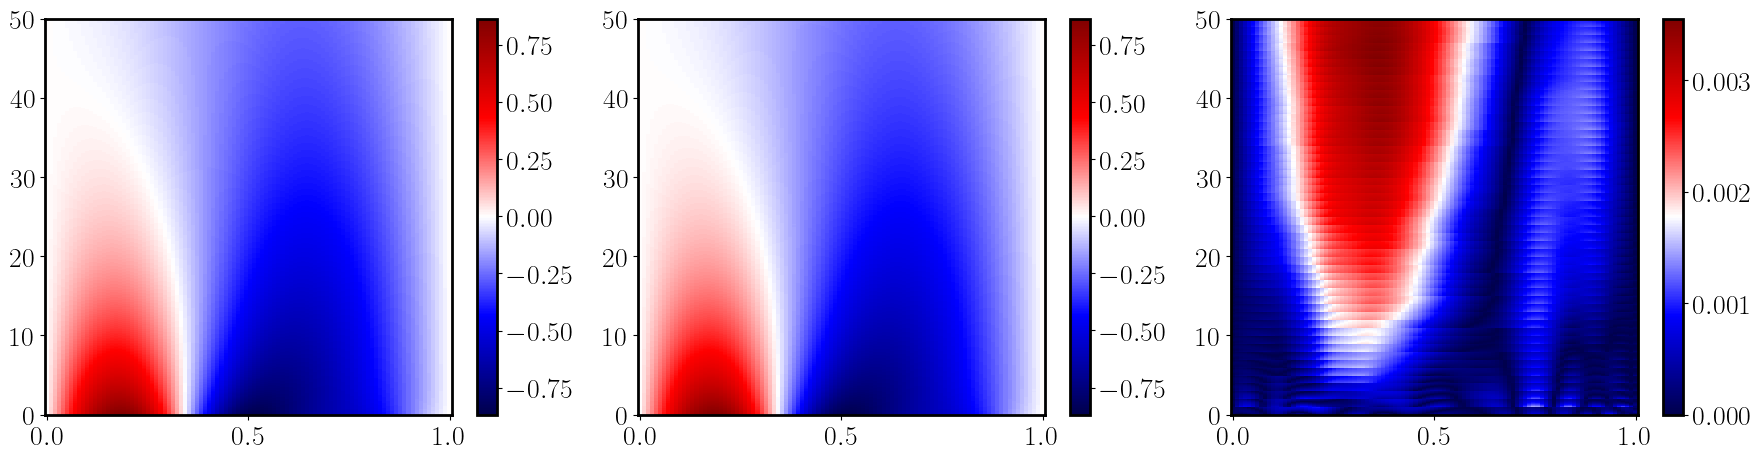

In [14]:
# Grid
x = np.linspace(0, 1, Nx)
t = np.linspace(0, N * dT, Nt)
XX, TT = np.meshgrid(x, t)

# Prediction
fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.pcolor(XX, TT, S_test.T, cmap='seismic')
plt.colorbar()
plt.tight_layout()

plt.subplot(1,3,2)
plt.pcolor(XX, TT, S_pred, cmap='seismic')
plt.colorbar()
plt.tight_layout()

plt.subplot(1,3,3)
plt.pcolor(XX, TT, np.abs(S_pred - S_test.T), cmap='seismic')
plt.colorbar()
plt.tight_layout()
plt.show()